Extension of the 1D problem solutions to the mass spring damper IVP. 


The difference with the diffusion problem of the first notebook, is that the boundary conditions are not dirichlet boundary conditions. Rather, it is an IVP so the initial value and derivative is prescribed.

The ansatz is still 
$$u=G(x)+D(x)*y^L$$
but to satisfy the IVP constraint, $G(0), G'(0)=y(0), y'(0)$ and $D, \frac{dD}{dx}=0$


This still follows Berg & Nystrom's approach, but their examples only covered Dirichlet boundary conditions. The Neumann BC's are the new thing here. 


Convergence issues seem to happen when the maximum time covered comes close to the period of motion. The residual does not decrease anymore after a few iterations, and is not satisfactory. It is unclear why this happens. Possible reasons: optimization hitting local minimum, or issues relating to periodicity (i.e. the ansatz is not capable of dealing with that). 


Todo: Improve the optimizer used to e.g. BFGS line search. Investigate layer size/depth effect. 

In [1]:
from sympy import init_printing
init_printing(use_latex=True) 

import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, jacobian
from autograd.misc.optimizers import adam
from functools import reduce

from reusable_functions import init_random_params, neural_net_predict, modded_basinhopping

In [2]:
#Problem Setup: 
#Make sure the residual and forcing functions correspond to your ODE.

c=0;
k=1.;
nl=0.6; #nonlinearity factor
forcing_fn = lambda x: 0.
layer_sizes=[1,10,10,1]
nx=100
u_0=1.; #initial position
v_0=1.; #initial velocity
G=lambda x:u_0+v_0*x #to satisfy BCs
#D=lambda x:x**2 #distance function
#D=lambda x:x*(8-x) #distance function
D=lambda x:x**2/(1+x**2) #distance function
x_space = np.linspace(0, 8, nx)
def u(params, x):
    return G(x)+D(x)*neural_net_predict(params, x)


du=grad(u,1)
du2=grad(du,1)

def resid(params, x): 
    return np.square(du2(params,x)+c*du(params,x)+k*u(params,x)+nl*(u(params,x))**3-forcing_fn(x))

In [3]:
def resid_batch(params, x_batch):
    resid_temp=list(map(lambda x: resid(params, x)**2, x_batch))
    resid_sum=reduce(lambda x,y:x+y, resid_temp)
    return resid_sum/len(x_batch)  
def loss_function(params):
    return resid_batch(params, x_space)

loss_grad=grad(loss_function)

x0=init_random_params(1, layer_sizes)
optimized_params, fun=modded_basinhopping(loss_function, loss_grad,x0, num_iter=0, max_bfgs_iter=300, ftol=1e-14)

/home/vassili/anaconda3/envs/thesis/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Start basinhopping.Current func val:[19098.48282221]
Basinhopping fun: f(x) = [0.00025257]
Call fun itself: [0.00025257]


Text(0.5, 1.0, 'phase portrait')

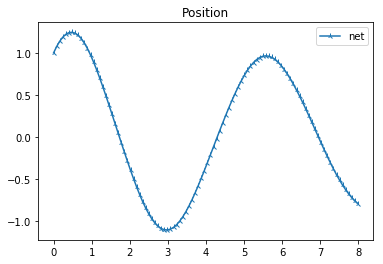

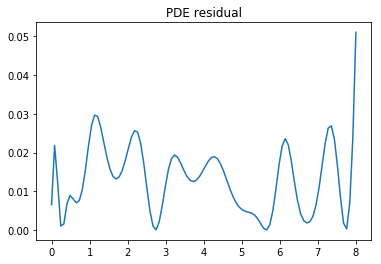

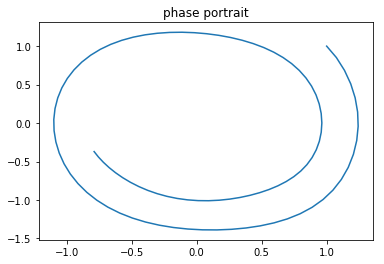

In [4]:
plt.figure
plt.clf()
ax=plt.gca()

sln = np.zeros(nx)

for i,x in enumerate(x_space):
    sln[i]=u(optimized_params, x)

plt.plot(x_space, sln, label='net', marker='2')
plt.title("Position")
ax.legend()

    
plt.figure()
pde_err=np.zeros(x_space.shape)
for i, x in enumerate(x_space):
    pde_err[i]=resid(optimized_params, x)

plt.plot(x_space, pde_err, label='error')
plt.title('PDE residual')

pos=np.zeros(x_space.shape)
vel=np.zeros(x_space.shape)

plt.figure()
for i, x in enumerate(x_space):
    pos[i]=u(optimized_params, x)
    vel[i]=du(optimized_params, x)
plt.plot(pos, vel, label='phase plot')
plt.title('phase portrait')